# Proyecto


Predicción del precio de carros por medio de un dataset extraído de Mercado Libre utilizando Web Scraping.

## Librerias

In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np

# Graphics
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# Preprocessing and Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

# Metrics
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score

# Persistence
from joblib import dump

import warnings
warnings.filterwarnings('ignore')

## Datos

In [ ]:
data = 'https://github.com/Gevorah/cars-prediction/raw/main/cars-mercadolibre.csv'

df = pd.read_csv(data)

## Análisis Exploratorio de los Datos

In [ ]:
df.head()

,bodywork_type,brand,city,color,doors,fuel_type,kilometers,model,motor,price,state,transmission,year
0,NaN,Kia,Kennedy,NaN,5.0,Gasolina,120.0,Picanto,NaN,49300000,Bogotá D.C.,Mecánica,2023.0
1,Sedán,Volkswagen,Suba,Rojo,5.0,Gasolina,126300.0,Jetta,2.0,31000000,Bogotá D.C.,Mecánica,2009.0
2,Camioneta,Nissan,Rafael Uribe Uribe,Verde,4.0,Gasolina,90884.0,D22,2400,61000000,Bogotá D.C.,Mecánica,2011.0
3,Camioneta,Ford,Usaquén,Azul,5.0,Gasolina,96200.0,Edge,3.5,58000000,Bogotá D.C.,Automática,2011.0
4,Hatchback,Mercedes-Benz,Cajicá,Blanco,5.0,Gasolina,102741.0,Clase B 180,NaN,46000000,Cundinamarca,Automática,2012.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27929 entries, 0 to 27928
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bodywork_type  22701 non-null  object 
 1   brand          27833 non-null  object 
 2   city           27929 non-null  object 
 3   color          16073 non-null  object 
 4   doors          27788 non-null  float64
 5   fuel_type      27830 non-null  object 
 6   kilometers     27833 non-null  float64
 7   model          27833 non-null  object 
 8   motor          22829 non-null  object 
 9   price          27929 non-null  int64  
 10  state          27929 non-null  object 
 11  transmission   27833 non-null  object 
 12  year           27833 non-null  float64
dtypes: float64(3), int64(1), object(9)
memory usage: 2.8+ MB


### Tipo de dato adecuado para cada feature

In [ ]:
numerical = []
categorical = []

for column in df.columns:
    if df[column].dtypes == object:
        df[column] = df[column].astype('string')
        categorical.append(column)
    else:
        df[column] = df[column].astype('float64')
        numerical.append(column)

print(df.dtypes)

bodywork_type     string
brand             string
city              string
color             string
doors            float64
fuel_type         string
kilometers       float64
model             string
motor             string
price            float64
state             string
transmission      string
year             float64
dtype: object


## Inconsistencias en el dataset

### Valores faltantes

In [ ]:
print('¿El conjunto de datos tiene valores faltantes? {}\n'.format(df.isnull().values.any()))

print('¿Cuántos nan tiene en total? {}\n'.format(df.isnull().sum().sum()))

nan_dict = {attr:df[attr].isnull().sum() for attr in df}
print('¿Cómo están distribuidos los nan? {}\n'.format(nan_dict))

¿El conjunto de datos tiene valores faltantes? True

¿Cuántos nan tiene en total? 22904

¿Cómo están distribuidos los nan? {'bodywork_type': 5228, 'brand': 96, 'city': 0, 'color': 11856, 'doors': 141, 'fuel_type': 99, 'kilometers': 96, 'model': 96, 'motor': 5100, 'price': 0, 'state': 0, 'transmission': 96, 'year': 96}



In [ ]:
# fill con features
for n in numerical:
  df[n] = df[n].fillna(df[n].mean())

# fill categorical features
for c in categorical:
  df[c] = df[c].fillna(df[c].mode()[0])

print('¿El conjunto de datos tiene valores faltantes? {}'.format(df.isnull().values.any()))

¿El conjunto de datos tiene valores faltantes? False


### Outliers

In [ ]:
def ranges(col):
  sorted(col)
  Q1, Q3 = col.quantile([0.25,0.75])
  IRQ = Q3 - Q1
  lower_range = Q1 - (1.5*IRQ)
  upper_range = Q3 + (1.5*IRQ)
  return lower_range, upper_range

#### Doors

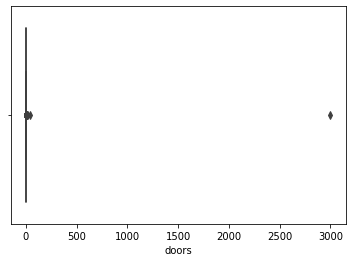

In [ ]:
ax = sns.boxplot(df['doors'])

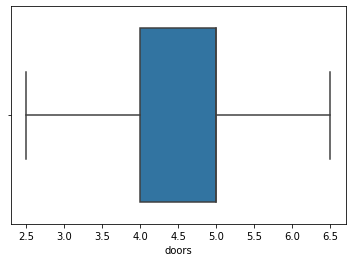

In [ ]:
lower_range, upper_range = ranges(df['doors'])

df['doors'] = np.where(df.doors<lower_range, lower_range, df.doors)
df['doors'] = np.where(df.doors>upper_range, upper_range, df.doors)

ax = sns.boxplot(df['doors'])

#### Year

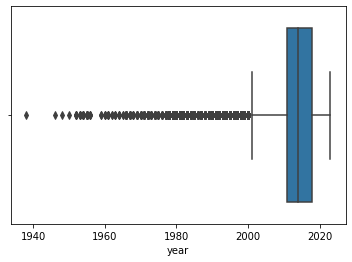

In [ ]:
ax = sns.boxplot(df['year'])

#### Kilometraje

In [ ]:
print((df.kilometers < 0).sum())

0


#### Price

In [ ]:
print((df.price < 0).sum())

0


### Eliminación de features innecesarios

In [ ]:
df.drop(columns='motor', axis=1, inplace=True)
categorical.remove('motor')

No se pudo recolectar apropiadamente los datos sobre el cilindraje, ya que en mercado libre los usuarios al hacer un post no llenarn correctamente el campo.

## Modelo

### Encoding

In [ ]:
X = df.copy()

for c in categorical:
    X[c] =  LabelEncoder().fit_transform(X[c]) + 1

# input variables
X.drop(columns='price', axis=1, inplace=True)

# output variables
y = df['price']

random_state = 42

X

,bodywork_type,brand,city,color,doors,fuel_type,kilometers,model,state,transmission,year
0,1,89,164,60,5.0,3,120.0,1106,4,3,2023.0
1,13,180,329,116,5.0,3,126300.0,843,4,3,2009.0
2,1,130,269,132,4.0,3,90884.0,548,4,3,2011.0
3,1,50,366,9,5.0,3,96200.0,609,4,1,2011.0
4,5,123,50,30,5.0,3,102741.0,463,13,1,2012.0
...,...,...,...,...,...,...,...,...,...,...,...
27924,13,8,164,132,4.0,3,77942.0,1317,4,1,2007.0
27925,1,128,251,116,5.0,3,145360.0,1004,4,3,2007.0
27926,13,25,329,60,5.0,3,194000.0,1659,4,3,2007.0
27927,1,172,78,60,5.0,3,198000.0,1116,4,3,2007.0


### Recursive Feature Elimination

In [ ]:
rfe = RFE(estimator=RandomForestRegressor(), n_features_to_select=5)
rfe = rfe.fit(X,y)
features = X.columns[rfe.support_]
print('Optimal number of features:', rfe.n_features_)
print('Best features:', np.array(features))

X = X[features]

Optimal number of features: 5
Best features: ['brand' 'kilometers' 'model' 'transmission' 'year']


### División de los datos

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X, y,
                                                     test_size=0.2,
                                                     random_state=random_state,
                                                     shuffle=True)

print('Training X Shape:', X_train.shape)
print('Training y Shape:', y_train.shape)
print('Testing X Shape:', X_test.shape)
print('Testing y Shape:', y_test.shape)

Training X Shape: (22343, 5)
Training y Shape: (22343,)
Testing X Shape: (5586, 5)
Testing y Shape: (5586,)


### Random Forest

In [ ]:
rf = RandomForestRegressor(random_state=random_state)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_train)

print("Performance with train data:", r2_score(y_train, y_pred))

Performance with train data: 0.7642423222379837


#### Predicciones con el set de pruebas

In [ ]:
y_pred = rf.predict(X_test)

print('Mean Squared Error:', MSE(y_test, y_pred))
print('Mean Absolute Error:', MAE(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Mean Squared Error: 1590243360432623.8
Mean Absolute Error: 11381295.704107447
R2 score: 0.6840553240144879


#### Visualización

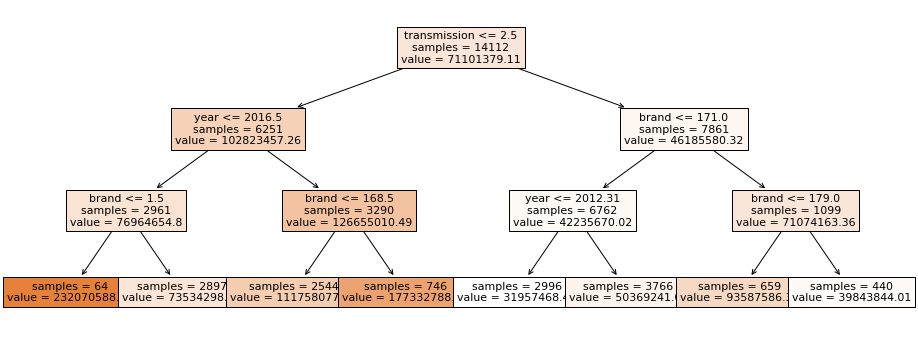

In [ ]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10,
                                 criterion='squared_error',
                                 max_depth=3,
                                 random_state=random_state)
rf_small.fit(X_train, y_train)

# Extract the small tree
tree_small = rf_small.estimators_[5]

fig = plt.figure(figsize=(16, 6))

plot = plot_tree(decision_tree = tree_small,
                 feature_names = features,
                 class_names   = 'price',
                 filled        = True,
                 impurity      = False,
                 fontsize      = 11,
                 precision     = 2)

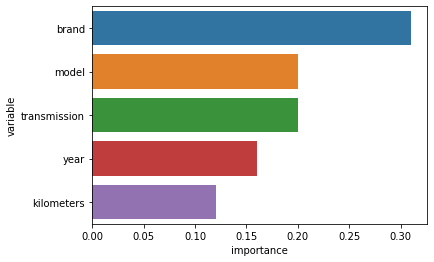

In [ ]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, 
importance in zip(features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

gdf = pd.DataFrame(feature_importances).rename(columns={0:'variable', 1:'importance'})

ax = sns.barplot(x='importance', y='variable', data=gdf)

### Hyperparameters Tuning

#### Randomized Search with Cross Validation

In [ ]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
rf_grid = {
  'bootstrap': [True],
  'max_depth': [20, 40, 60, 80, 100, None],
  'min_samples_leaf': [1, 2, 4],
  'min_samples_split': [2, 5, 10],
  'n_estimators': [100, 300, 600, 900]
}

#random_search = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=rf_grid, n_iter=50, n_jobs=-1, cv=5, verbose=2, random_state=random_state)

#random_search.fit(X_train, y_train)

#random_search.best_params_

In [ ]:
rf_tuned = RandomForestRegressor(bootstrap=True, max_depth=60, min_samples_leaf=1, 
                                 min_samples_split=5, n_estimators=900, random_state=random_state)

rf_tuned.fit(X_train, y_train)

y_pred = rf_tuned.predict(X_train)

print("Performance with train data:", r2_score(y_train, y_pred))

Performance with train data: 0.750131528730202


In [ ]:
y_pred = rf.predict(X_test)

print('Mean Squared Error:', MSE(y_test, y_pred))
print('Mean Absolute Error:', MAE(y_test, y_pred))
print('R2 score:', r2_score(y_test, y_pred))

Mean Squared Error: 1590243360432623.8
Mean Absolute Error: 11381295.704107447
R2 score: 0.6840553240144879


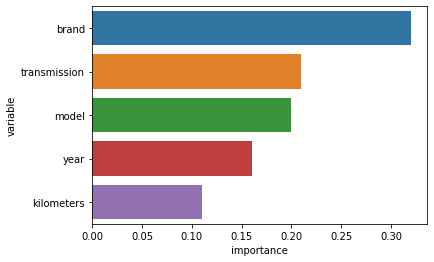

In [ ]:
# Get numerical feature importances
importances = list(rf_tuned.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, 
importance in zip(features, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

gdf = pd.DataFrame(feature_importances).rename(columns={0:'variable', 1:'importance'})

ax = sns.barplot(x='importance', y='variable', data=gdf)

### Predicciones

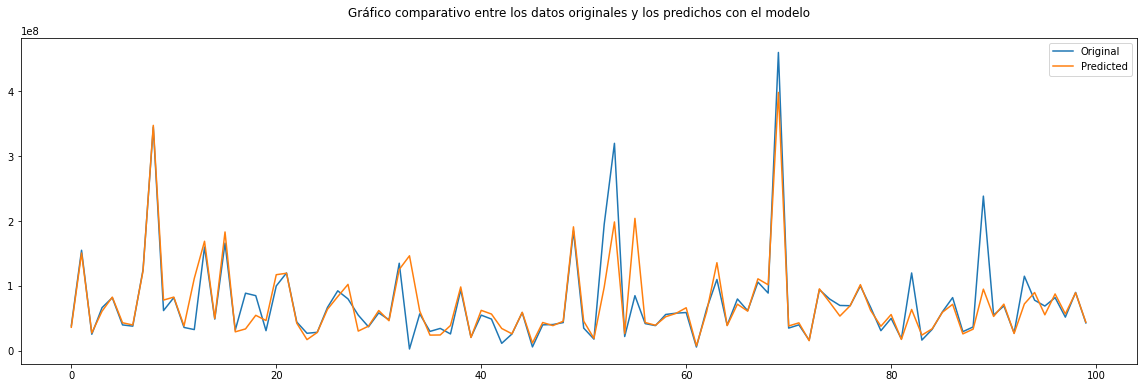

In [ ]:
fig = plt.figure(figsize=(20,6))

predictions = rf_tuned.predict(X_test)

x_ax = range(len(y_test.iloc[0:100]))
plt.plot(x_ax, y_test[0:100], label="Original")
plt.plot(x_ax, predictions[0:100], label= "Predicted")
plt.title("Gráfico comparativo entre los datos originales y los predichos con el modelo\n")
plt.legend()

## Exportar el Modelo final

In [ ]:
dump(rf_tuned, 'car-predict.joblib')

['car-predict.joblib']

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=511ee041-b4b1-4cd3-b8ea-b2652010eed2' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>